In [1]:
#import modules
import numpy as np 
import pandas as pd 
import nltk
import tensorflow as tf
import io
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#dowloading stop words from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#declaring stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [4]:
#reading in the dataset
data = pd.read_csv('bbc-news-data.csv', sep = '\t')
data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [8]:
sentences = list(data.content)

In [9]:
print(len(sentences))

2225


In [10]:
#removing stopwords from each of the texts
for idx in range(len(sentences)):
  sentence = sentences[idx]
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
    sentence = sentence.replace("  ", " ")
  sentences[idx] = sentence

In [11]:
labels = list(data.category)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 30000
embedding_dim = 32
max_length = 128

In [13]:
#Function for plotting history of loss and accuracy
def plot_history(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    

In [25]:
#Splitting dataset in train and dev sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, train_size = 0.8, random_state = 1, shuffle = True)

In [26]:
#tokenize data
#declare tkenizer
tokenizer = Tokenizer(num_words = 15000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)#fit tokernizer on dataset
word_index = tokenizer.word_index
#Preprocessing train and dev set for inputting to model
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=max_length)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=max_length)


In [16]:
#saving tokernizer to tokenizer.json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [27]:
#Creating tokens for the labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_index = label_tokenizer.word_index

In [28]:
print(label_index)

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


In [29]:
#preprocessing Y_train and y_test
y_train_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
y_test_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [30]:
#creating base model and compiling
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
#training base model
history = model.fit(X_train_padded, y_train_label_seq, epochs=15, validation_data=(X_test_padded, y_test_label_seq), verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 32)           960000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 983,078
Trainable params: 983,078
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
56/56 - 10s - loss: 1.6173 - accuracy: 0.3034 - val_loss: 1.2032 - val_accuracy: 0.3933
Epoch 2/15
56/5

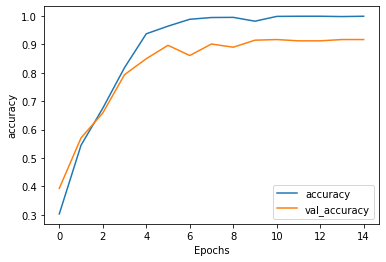

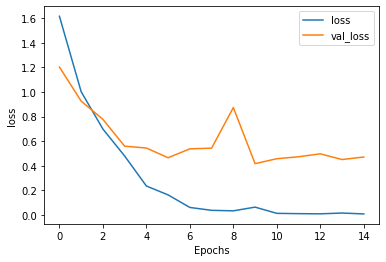

In [31]:
#plotting loss and accuracy history
plot_history(history, 'accuracy')
plot_history(history, 'loss')

In [32]:
#Predictions on dev set
labels_pred = np.argmax(model.predict(X_test_padded),axis = -1)
print(labels_pred[0:20])
print(y_test_label_seq[0:20].reshape( 1, -1))

[1 1 2 1 1 1 1 3 5 5 3 2 4 5 1 4 2 1 3 3]
[[1 1 2 1 1 1 1 3 5 5 3 2 4 5 1 4 2 1 3 3]]


In [33]:
#accuracy scores
from sklearn.metrics import accuracy_score
print("Base model accuracy on dev set: ")
print(accuracy_score(labels_pred,y_test_label_seq))

Base model accuracy on dev set: 
0.9168539325842696


In [34]:
#declaring submodel to save
submodel = tf.keras.Model(inputs =  model.input, outputs = model.get_layer("dense_7").output)
submodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2_input (InputLaye [(None, 128)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 32)           960000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
Total params: 982,880
Trainable params: 982,880
Non-trainable params: 0
_________________________________________________________________


In [35]:
#compiling submodel
submodel.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
#saving submodel as submodel.h5
submodel.save('submodel.h5')